In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-cars-price-prediction/test-data.csv
/kaggle/input/used-cars-price-prediction/train-data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='ggplot')
%matplotlib inline

In [3]:
# Loading the data
train = pd.read_csv('../input/used-cars-price-prediction/train-data.csv')
test = pd.read_csv('../input/used-cars-price-prediction/test-data.csv')
print(train.shape)
print(train.info())
print(test.shape)
print(test.info())

(6019, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB
None
(1234, 13)
<class 'pandas.core.frame.DataFram

In [4]:
train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [5]:
test.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998 CC,58.2 bhp,4.0,NaN
1,1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN
2,2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7.0,25.27 Lakh
3,3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364 CC,null bhp,5.0,NaN
4,4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197 CC,82.85 bhp,5.0,NaN


In [6]:
print(train.shape, test.shape)
train.drop('New_Price', axis=1, inplace=True)
test.drop('New_Price', axis=1, inplace=True)
print(train.shape, test.shape)

(6019, 14) (1234, 13)
(6019, 13) (1234, 12)


# Data Cleaning and Feature Engineering

In [7]:
print(train.isnull().sum())
print("------------------------")
print(test.isnull().sum())

Unnamed: 0            0
Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64
------------------------
Unnamed: 0            0
Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               0
Engine               10
Power                10
Seats                11
dtype: int64


In [8]:
print(train['Unnamed: 0'].value_counts())

2047    1
2720    1
2708    1
661     1
4759    1
       ..
5436    1
1342    1
3391    1
5440    1
0       1
Name: Unnamed: 0, Length: 6019, dtype: int64


In [9]:
unnamed_train = list(train['Unnamed: 0'].unique())
unnamed_test = list(test['Unnamed: 0'].unique())
for i in unnamed_test:
    if i not in unnamed_train:
        print(i)

## Name

In [10]:
print(train['Name'].value_counts())
print(train['Unnamed: 0'].value_counts())

Mahindra XUV500 W8 2WD              49
Maruti Swift VDI                    45
Honda City 1.5 S MT                 34
Maruti Swift Dzire VDI              34
Maruti Swift VDI BSIV               31
                                    ..
Mahindra Scorpio S10 7 Seater        1
Tata New Safari DICOR 2.2 VX 4x2     1
Mahindra Bolero mHAWK D70 ZLX        1
Mini Clubman Cooper S                1
BMW X3 xDrive20d Expedition          1
Name: Name, Length: 1876, dtype: int64
2047    1
2720    1
2708    1
661     1
4759    1
       ..
5436    1
1342    1
3391    1
5440    1
0       1
Name: Unnamed: 0, Length: 6019, dtype: int64


In [11]:
print(test['Name'].value_counts())

Maruti Alto LXi                        9
Volkswagen Polo 1.2 MPI Highline       8
Honda City 1.5 V MT                    8
Maruti Swift Dzire VDI                 8
Hyundai i10 Magna                      7
                                      ..
Hyundai Grand i10 CRDi Sportz          1
BMW 5 Series 530i Sport Line           1
Honda WRV i-DTEC VX                    1
Volkswagen Polo 1.5 TDI Comfortline    1
Skoda Laura Ambiente 2.0 TDI CR AT     1
Name: Name, Length: 768, dtype: int64


In [12]:
print(test['Name'].value_counts())

Maruti Alto LXi                        9
Volkswagen Polo 1.2 MPI Highline       8
Honda City 1.5 V MT                    8
Maruti Swift Dzire VDI                 8
Hyundai i10 Magna                      7
                                      ..
Hyundai Grand i10 CRDi Sportz          1
BMW 5 Series 530i Sport Line           1
Honda WRV i-DTEC VX                    1
Volkswagen Polo 1.5 TDI Comfortline    1
Skoda Laura Ambiente 2.0 TDI CR AT     1
Name: Name, Length: 768, dtype: int64


In [13]:
print(train.shape, test.shape)
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)
print(train.shape, test.shape)

(6019, 13) (1234, 12)
(6019, 12) (1234, 11)


## Location

In [14]:
train['Location'][:20]

0         Mumbai
1           Pune
2        Chennai
3        Chennai
4     Coimbatore
5      Hyderabad
6         Jaipur
7         Mumbai
8           Pune
9        Chennai
10         Kochi
11       Kolkata
12        Jaipur
13         Delhi
14          Pune
15         Delhi
16         Kochi
17        Jaipur
18         Kochi
19     Bangalore
Name: Location, dtype: object

In [15]:
train['Location'].value_counts()

Mumbai        790
Hyderabad     742
Kochi         651
Coimbatore    636
Pune          622
Delhi         554
Kolkata       535
Chennai       494
Jaipur        413
Bangalore     358
Ahmedabad     224
Name: Location, dtype: int64

In [16]:
test['Location'].value_counts()

Mumbai        159
Pune          143
Coimbatore    136
Hyderabad     134
Kochi         121
Kolkata       119
Delhi         106
Chennai        97
Jaipur         86
Bangalore      82
Ahmedabad      51
Name: Location, dtype: int64

## Kilometers_Driven

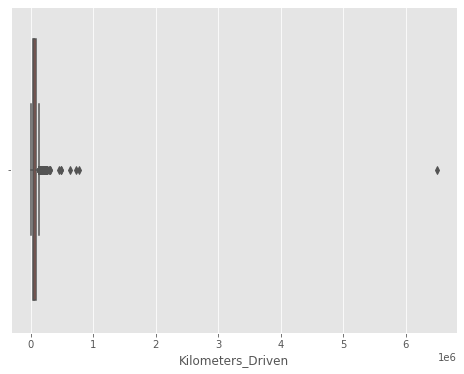

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(train['Kilometers_Driven'])
plt.show()

In [18]:
temp2 = test[test['Kilometers_Driven'] > 400000]
temp2

,Unnamed: 0,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats


In [19]:
print(train.shape)
temp = train[train['Kilometers_Driven'] > 400000].index
train.drop(temp, axis=0, inplace=True)
print(train.shape)

(6019, 12)
(6012, 12)


## Fuel Type

In [20]:
train['Fuel_Type'][:20]

0        CNG
1     Diesel
2     Petrol
3     Diesel
4     Diesel
5        LPG
6     Diesel
7     Diesel
8     Diesel
9     Diesel
10    Petrol
11    Petrol
12    Diesel
13    Diesel
14    Diesel
15    Diesel
16    Diesel
17    Diesel
18    Diesel
19    Diesel
Name: Fuel_Type, dtype: object

In [21]:
train['Fuel_Type'].value_counts()

Diesel      3201
Petrol      2743
CNG           56
LPG           10
Electric       2
Name: Fuel_Type, dtype: int64

In [22]:
test['Fuel_Type'].value_counts()

Diesel    647
Petrol    579
CNG         6
LPG         2
Name: Fuel_Type, dtype: int64

## Transmission

In [23]:
train['Transmission'][:20]

0        Manual
1        Manual
2        Manual
3        Manual
4     Automatic
5        Manual
6        Manual
7     Automatic
8        Manual
9        Manual
10       Manual
11    Automatic
12       Manual
13    Automatic
14    Automatic
15       Manual
16       Manual
17       Manual
18       Manual
19    Automatic
Name: Transmission, dtype: object

In [24]:
train['Transmission'].value_counts()

Manual       4295
Automatic    1717
Name: Transmission, dtype: int64

In [25]:
test['Transmission'].value_counts()

Manual       905
Automatic    329
Name: Transmission, dtype: int64

## Owner_Type

In [26]:
train['Owner_Type'][:20]

0      First
1      First
2      First
3      First
4     Second
5      First
6      First
7      First
8      First
9     Second
10     First
11     First
12     First
13     First
14    Second
15     First
16     First
17     First
18     First
19     First
Name: Owner_Type, dtype: object

In [27]:
train['Owner_Type'].value_counts()

First             4922
Second             968
Third              113
Fourth & Above       9
Name: Owner_Type, dtype: int64

In [28]:
test['Owner_Type'].value_counts()

First             1023
Second             184
Third               24
Fourth & Above       3
Name: Owner_Type, dtype: int64

## Mileage

In [29]:
train['Mileage'][:20]

0     26.6 km/kg
1     19.67 kmpl
2      18.2 kmpl
3     20.77 kmpl
4      15.2 kmpl
5     21.1 km/kg
6     23.08 kmpl
7     11.36 kmpl
8     20.54 kmpl
9      22.3 kmpl
10    21.56 kmpl
11     16.8 kmpl
12     25.2 kmpl
13     12.7 kmpl
14      0.0 kmpl
15     13.5 kmpl
16     25.8 kmpl
17     28.4 kmpl
18    20.45 kmpl
19    14.84 kmpl
Name: Mileage, dtype: object

- km/kg: Kilometers per Kilogram
- kmpl: Kilometers per Litre

In [30]:
train['Mileage'].value_counts(dropna=False)

18.9 kmpl     172
17.0 kmpl     172
18.6 kmpl     119
20.36 kmpl     87
21.1 kmpl      86
             ... 
7.5 kmpl        1
26.8 kmpl       1
23.03 kmpl      1
25.01 kmpl      1
14.47 kmpl      1
Name: Mileage, Length: 443, dtype: int64

In [31]:
# Null Values
train['Mileage'] = train['Mileage'].fillna('17.0 kmpl')

In [32]:
train['Mileage'][0].split()[0], train['Mileage'][0].split()[1]

('26.6', 'km/kg')

In [33]:
mile_age_val = pd.DataFrame(columns=['Mileage_value'])
mile_age_measure = pd.DataFrame(columns=['Mileage_measure'])
train = pd.concat([train, mile_age_val, mile_age_measure], axis=1)
test = pd.concat([test, mile_age_val, mile_age_measure], axis=1)

for i in train.index:
    value = train['Mileage'][i].split()[0]
    measure = train['Mileage'][i].split()[1]
    train['Mileage_value'][i] = value
    train['Mileage_measure'][i] = measure
    
for i in test.index:
    value = test['Mileage'][i].split()[0]
    measure = test['Mileage'][i].split()[1]
    test['Mileage_value'][i] = value
    test['Mileage_measure'][i] = measure
    
train.drop('Mileage', axis=1, inplace=True)
test.drop('Mileage', axis=1, inplace=True)

## Engine

In [34]:
train['Engine'][:20]

0      998 CC
1     1582 CC
2     1199 CC
3     1248 CC
4     1968 CC
5      814 CC
6     1461 CC
7     2755 CC
8     1598 CC
9     1248 CC
10    1462 CC
11    1497 CC
12    1248 CC
13    2179 CC
14    2179 CC
15    2477 CC
16    1498 CC
17    1248 CC
18    1461 CC
19    2143 CC
Name: Engine, dtype: object

In [35]:
train['Engine'].value_counts()

1197 CC    604
1248 CC    512
1498 CC    304
998 CC     259
2179 CC    240
          ... 
4951 CC      1
2694 CC      1
1422 CC      1
2720 CC      1
2706 CC      1
Name: Engine, Length: 146, dtype: int64

In [36]:
test['Engine'].value_counts()

1197 CC    126
1248 CC     98
1498 CC     66
1198 CC     54
998 CC      50
          ... 
793 CC       1
4395 CC      1
1948 CC      1
5998 CC      1
2198 CC      1
Name: Engine, Length: 104, dtype: int64

In [37]:
# Null Values
train['Engine'] = train['Engine'].fillna('1197 CC')
test['Engine'] = test['Engine'].fillna('1197 CC')

In [38]:
train['Engine'][0].split()[0], train['Engine'][0].split()[1]

('998', 'CC')

In [39]:
engine_val = pd.DataFrame(columns=['Engine_value'])
engine_measure = pd.DataFrame(columns=['Engine_measure'])
train = pd.concat([train, engine_val, engine_measure], axis=1)
test = pd.concat([test, engine_val, engine_measure], axis=1)

for i in train.index:
    value = train['Engine'][i].split()[0]
    measure = train['Engine'][i].split()[1]
    train['Engine_value'][i] = value
    train['Engine_measure'][i] = measure
        
for i in test.index:
    value = test['Engine'][i].split()[0]
    measure = test['Engine'][i].split()[1]
    test['Engine_value'][i] = value
    test['Engine_measure'][i] = measure
    
train.drop('Engine', axis=1, inplace=True)
test.drop('Engine', axis=1, inplace=True)

In [40]:
train['Engine_measure'].value_counts()

CC    6012
Name: Engine_measure, dtype: int64

In [41]:
train.drop('Engine_measure', axis=1, inplace=True)
test.drop('Engine_measure', axis=1, inplace=True)

In [42]:
train.shape, test.shape

((6012, 13), (1234, 12))

## Power

In [43]:
train['Power'].value_counts()

74 bhp        235
98.6 bhp      131
73.9 bhp      125
140 bhp       123
78.9 bhp      110
             ... 
168 bhp         1
74.93 bhp       1
127 bhp         1
246.74 bhp      1
89.75 bhp       1
Name: Power, Length: 372, dtype: int64

In [44]:
test['Power'].value_counts()

74 bhp        45
98.6 bhp      35
73.9 bhp      27
82 bhp        23
null bhp      22
              ..
123.7 bhp      1
364.9 bhp      1
261.49 bhp     1
198.25 bhp     1
115 bhp        1
Name: Power, Length: 249, dtype: int64

In [45]:
# Null Values
train['Power'] = train['Power'].fillna('74 bhp')
test['Power'] = test['Power'].fillna('74 bhp')

In [46]:
power_val = pd.DataFrame(columns=['Power_value'])
power_measure = pd.DataFrame(columns=['Power_measure'])
train = pd.concat([train, power_val, power_measure], axis=1)
test = pd.concat([test, power_val, power_measure], axis=1)

for i in train.index:
    value = train['Power'][i].split()[0]
    measure = train['Power'][i].split()[1]
    train['Power_value'][i] = value
    train['Power_measure'][i] = measure
        
for i in test.index:
    value = test['Power'][i].split()[0]
    measure = test['Power'][i].split()[1]
    test['Power_value'][i] = value
    test['Power_measure'][i] = measure
    
train.drop('Power', axis=1, inplace=True)
test.drop('Power', axis=1, inplace=True)

In [47]:
train['Power_measure'].value_counts()

bhp    6012
Name: Power_measure, dtype: int64

In [48]:
train.head()

,Unnamed: 0,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Mileage_value,Mileage_measure,Engine_value,Power_value,Power_measure
0,0,Mumbai,2010,72000,CNG,Manual,First,5.0,1.75,26.6,km/kg,998,58.16,bhp
1,1,Pune,2015,41000,Diesel,Manual,First,5.0,12.50,19.67,kmpl,1582,126.2,bhp
2,2,Chennai,2011,46000,Petrol,Manual,First,5.0,4.50,18.2,kmpl,1199,88.7,bhp
3,3,Chennai,2012,87000,Diesel,Manual,First,7.0,6.00,20.77,kmpl,1248,88.76,bhp
4,4,Coimbatore,2013,40670,Diesel,Automatic,Second,5.0,17.74,15.2,kmpl,1968,140.8,bhp


In [49]:
train['Power_value'].fillna('74', inplace=True)
test['Power_value'].fillna('74', inplace=True)

In [50]:
train.drop('Power_measure', axis=1, inplace=True)
test.drop('Power_measure', axis=1, inplace=True)

## Seats

In [51]:
train['Seats'].value_counts()

5.0     5007
7.0      674
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
0.0        1
Name: Seats, dtype: int64

In [52]:
test['Seats'].value_counts()

5.0     1033
7.0      122
8.0       36
4.0       20
6.0        7
10.0       3
2.0        2
Name: Seats, dtype: int64

In [53]:
# Null values
train['Seats'] = train['Seats'].fillna(5.0)
test['Seats'] = test['Seats'].fillna(5.0)

# EDA

In [54]:
train['Unnamed: 0'].value_counts()

2047    1
673     1
661     1
4759    1
2712    1
       ..
5440    1
1346    1
3395    1
5444    1
0       1
Name: Unnamed: 0, Length: 6012, dtype: int64

In [55]:
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

## Location

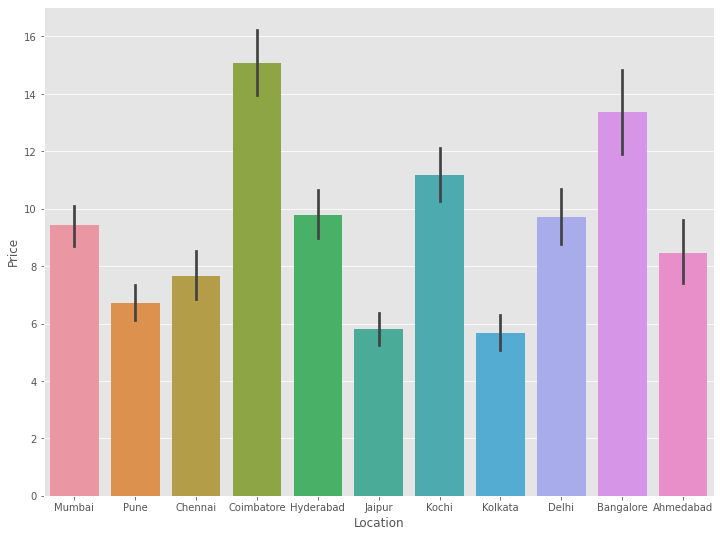

In [56]:
plt.figure(figsize=(12, 9))
sns.barplot('Location', 'Price', data=train)

## Year

<Figure size 864x648 with 0 Axes>

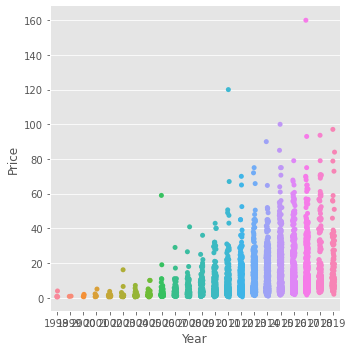

In [57]:
plt.figure(figsize=(12, 9))
sns.catplot('Year', 'Price', data=train)

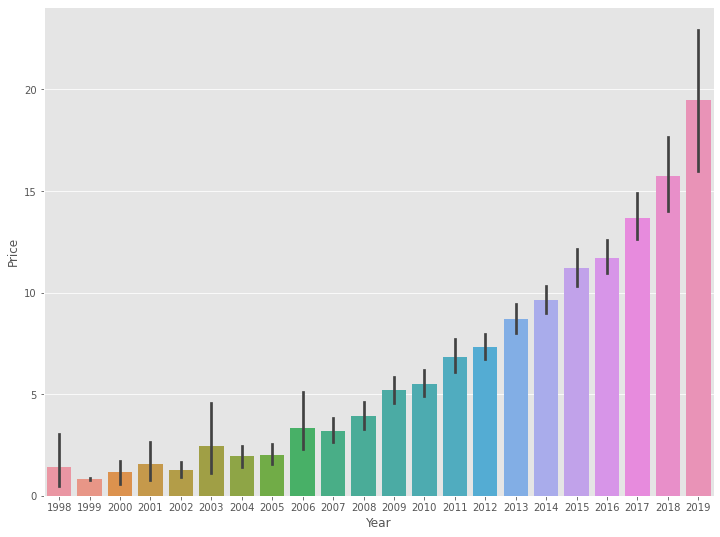

In [58]:
plt.figure(figsize=(12, 9))
sns.barplot('Year', 'Price', data=train)

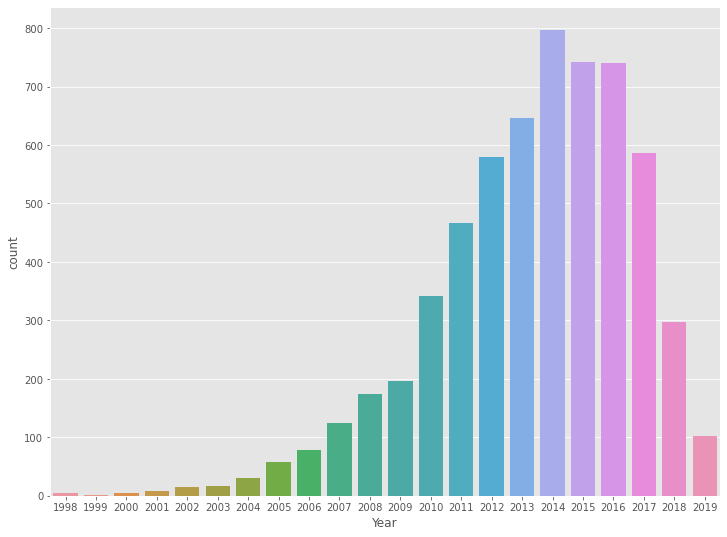

In [59]:
plt.figure(figsize=(12, 9))
sns.countplot('Year', data=train)

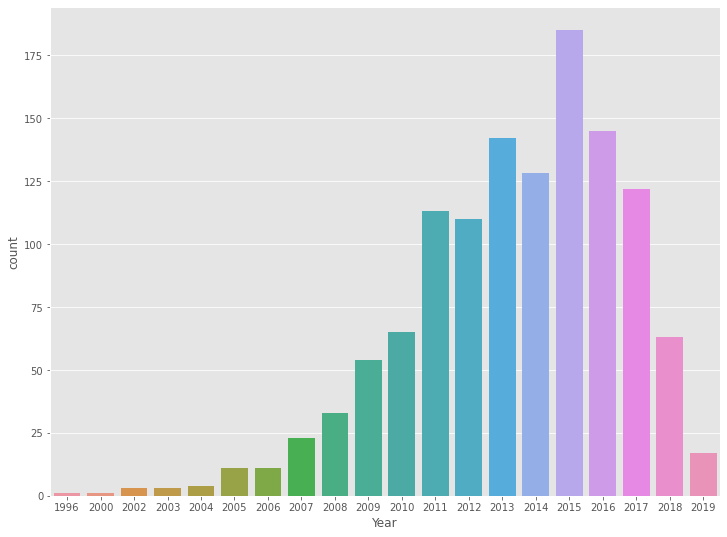

In [60]:
plt.figure(figsize=(12, 9))
sns.countplot('Year', data=test)

I guess it would be reasonable to generate a new feature like 'is_after_2014'

## Kilometers_Driven

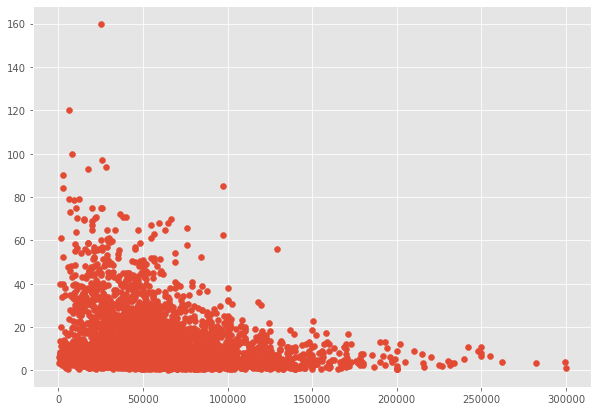

In [61]:
plt.figure(figsize=(10, 7))
plt.scatter(train['Kilometers_Driven'], train['Price'])

Generating new feature 'is_kilometers_driven_less_80k' would be useful

## Fuel_Type

<Figure size 720x504 with 0 Axes>

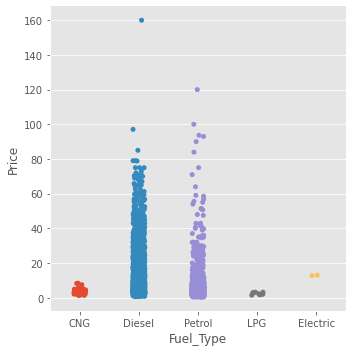

In [62]:
plt.figure(figsize=(10, 7))
sns.catplot('Fuel_Type', 'Price', data=train)

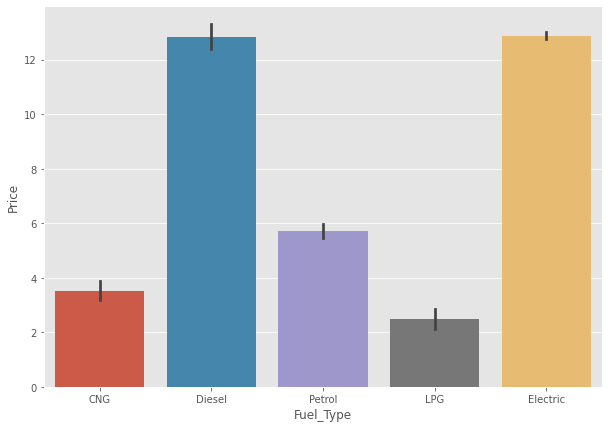

In [63]:
plt.figure(figsize=(10, 7))
sns.barplot('Fuel_Type', 'Price', data=train)

In [64]:
test['Fuel_Type'].value_counts()

Diesel    647
Petrol    579
CNG         6
LPG         2
Name: Fuel_Type, dtype: int64

## Transmission

<Figure size 720x504 with 0 Axes>

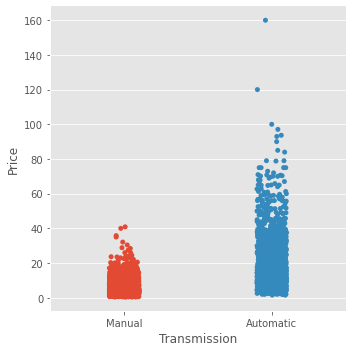

In [65]:
plt.figure(figsize=(10, 7))
sns.catplot('Transmission', 'Price', data=train)

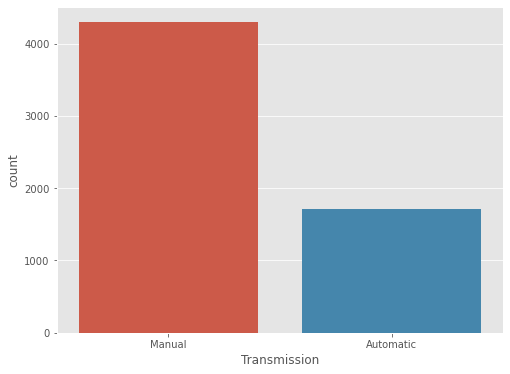

In [66]:
plt.figure(figsize=(8, 6))
sns.countplot('Transmission', data=train)

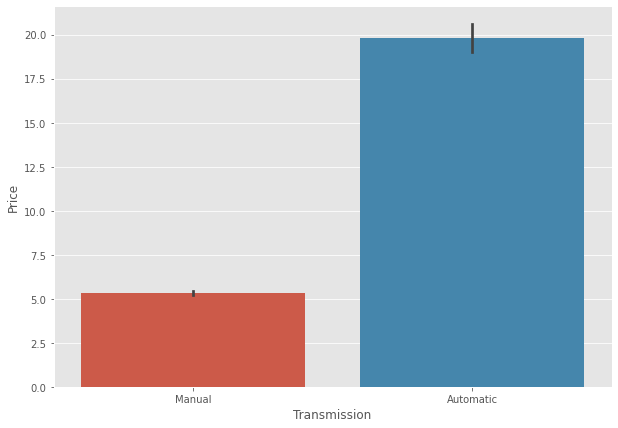

In [67]:
plt.figure(figsize=(10, 7))
sns.barplot('Transmission', 'Price', data=train)

Generating 'is_automatic' would be great!

## Owner_Type

<Figure size 720x504 with 0 Axes>

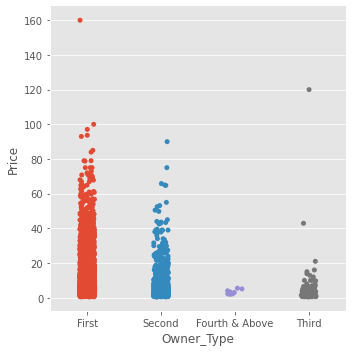

In [68]:
plt.figure(figsize=(10, 7))
sns.catplot('Owner_Type', 'Price', data=train)

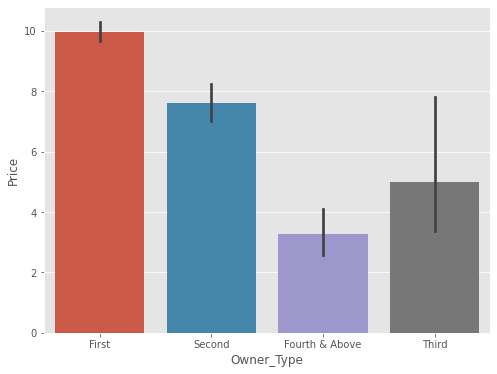

In [69]:
plt.figure(figsize=(8, 6))
sns.barplot('Owner_Type', 'Price', data=train)

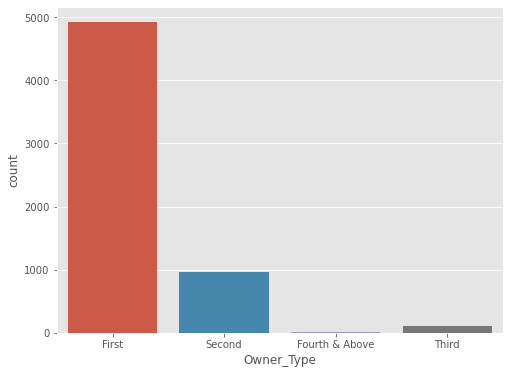

In [70]:
plt.figure(figsize=(8, 6))
sns.countplot('Owner_Type', data=train)

## Seats

In [71]:
print(train['Seats'].value_counts())
print(test['Seats'].value_counts())

5.0     5049
7.0      674
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
0.0        1
Name: Seats, dtype: int64
5.0     1044
7.0      122
8.0       36
4.0       20
6.0        7
10.0       3
2.0        2
Name: Seats, dtype: int64


In [72]:
train['Seats'].isna().sum()

0

In [73]:
print(train.shape)
train = train[train['Seats'] != 0]
print(train.shape)

(6012, 12)
(6011, 12)


In [74]:
train['Seats'].fillna(train['Seats'].median(), inplace=True)

<Figure size 576x432 with 0 Axes>

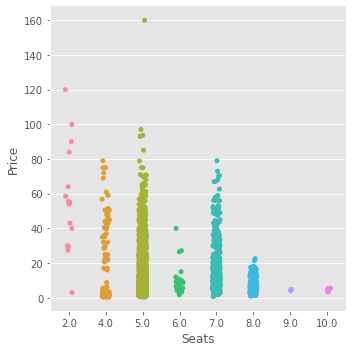

In [75]:
plt.figure(figsize=(8, 6))
sns.catplot('Seats', 'Price', data=train)

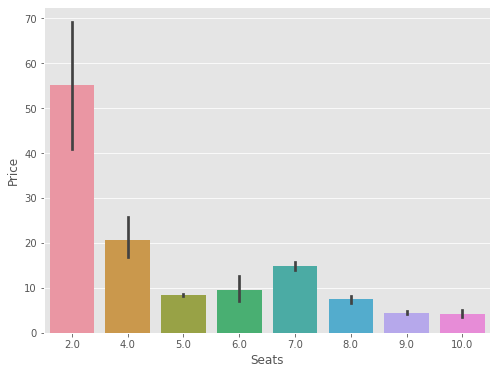

In [76]:
plt.figure(figsize=(8, 6))
sns.barplot('Seats', 'Price', data=train)

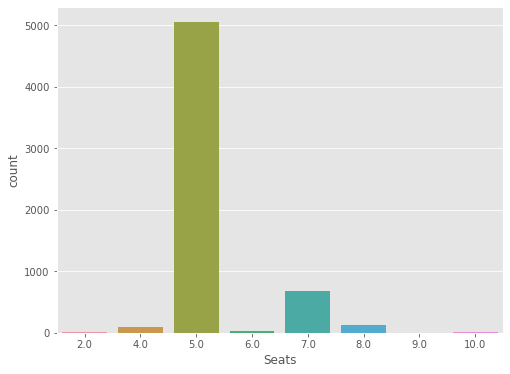

In [77]:
plt.figure(figsize=(8, 6))
sns.countplot('Seats', data=train)

# Encoding Categorical Features

In [78]:
for i in train.columns:
    print(i, len(train[i].unique()))

Location 11
Year 22
Kilometers_Driven 3087
Fuel_Type 5
Transmission 2
Owner_Type 4
Seats 8
Price 1373
Mileage_value 430
Mileage_measure 2
Engine_value 145
Power_value 372


In [79]:
train['Kilometers_Binned'] = pd.cut(train['Kilometers_Driven'], bins=4)

In [80]:
ohe_cols = ['Fuel_Type', 'Seats', 'Owner_Type']
binary_cols = ['Mileage_measure', 'Transmission']
train = pd.get_dummies(train, columns=ohe_cols)
train = pd.get_dummies(train, columns=binary_cols, drop_first=True)

test = pd.get_dummies(test, columns=ohe_cols)
test = pd.get_dummies(test, columns=binary_cols, drop_first=True)

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6011 entries, 0 to 6018
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Location                   6011 non-null   object  
 1   Year                       6011 non-null   int64   
 2   Kilometers_Driven          6011 non-null   int64   
 3   Price                      6011 non-null   float64 
 4   Mileage_value              6011 non-null   object  
 5   Engine_value               6011 non-null   object  
 6   Power_value                6011 non-null   object  
 7   Kilometers_Binned          6011 non-null   category
 8   Fuel_Type_CNG              6011 non-null   uint8   
 9   Fuel_Type_Diesel           6011 non-null   uint8   
 10  Fuel_Type_Electric         6011 non-null   uint8   
 11  Fuel_Type_LPG              6011 non-null   uint8   
 12  Fuel_Type_Petrol           6011 non-null   uint8   
 13  Seats_2.0                  6011 non-nu

In [82]:
le = LabelEncoder()
for col in train.select_dtypes(include=['object','category']):
    train[col] = le.fit_transform(train[col])
for col in test.select_dtypes(include=['object','category']):
    test[col] = le.fit_transform(test[col])

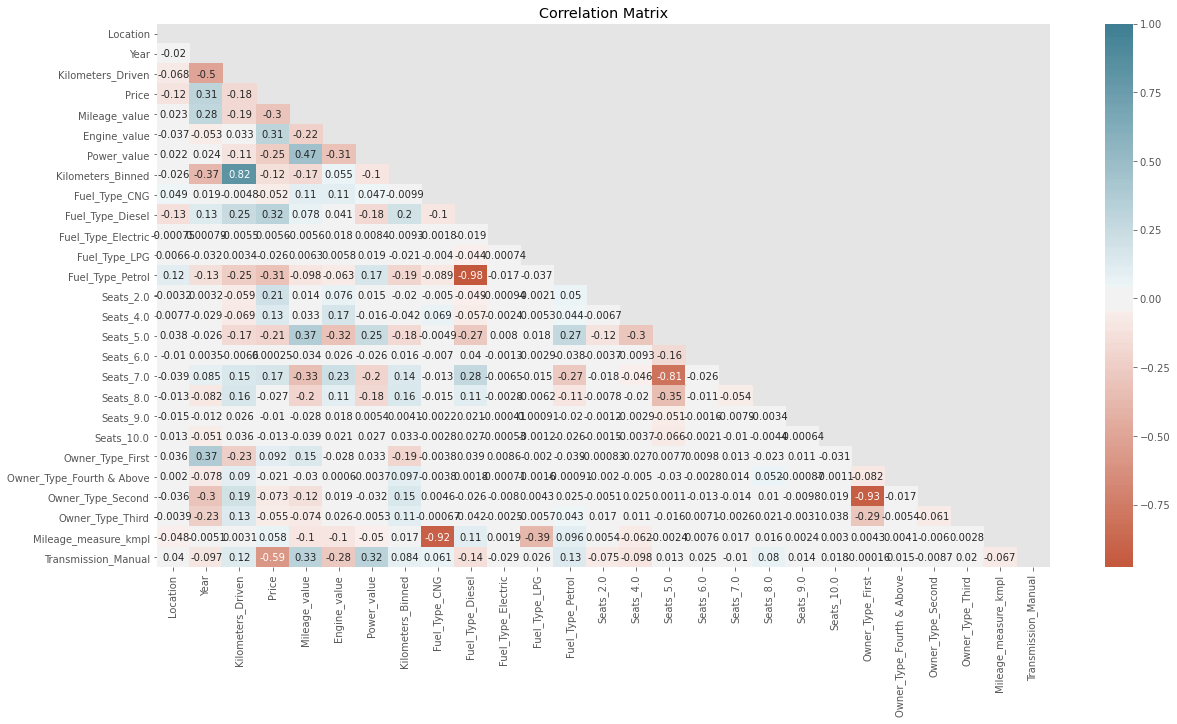

Top 3 features highly correlated with 'Price' are: Transmission_Manual Fuel_Type_Diesel Fuel_Type_Petrol



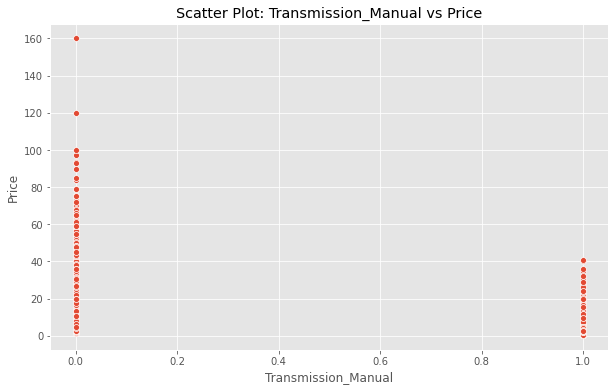

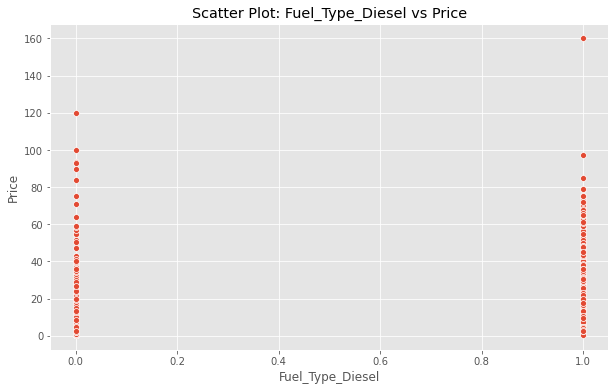

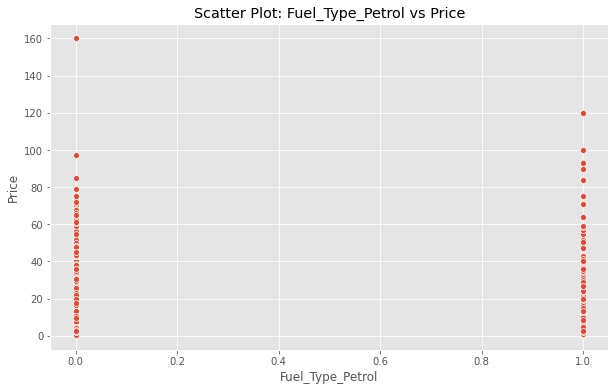

In [83]:
corr_matrix = train.corr()
fig, ax = plt.subplots(figsize=(20, 10))
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center=0)
plt.title('Correlation Matrix')
plt.show()

# Find the top 3 features that have the highest correlation with the target variable 'Price'
top_features = corr_matrix['Price'].abs().sort_values(ascending=False).index[1:4]
print("Top 3 features highly correlated with 'Price' are:", top_features[0], top_features[1], top_features[2])
print()
# Plot scatter plots for the top 3 features against 'Price'
for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=train, x=feature, y='Price')
    plt.title(f'Scatter Plot: {feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

In [84]:
train_target = train['Price']
train = train.drop(columns=['Price'])
feature_names = train.columns.tolist()
scaler = StandardScaler()
train = scaler.fit_transform(train)
X_train, X_dev, y_train, y_dev = train_test_split(train, train_target, test_size=0.2, random_state=42)

In [85]:
# Function to perform grid search and return best model and its RMSE
def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0)
    grid_search.fit(X_train, y_train)
    return grid_search

In [86]:
# Define parameter grids for each model
lgb_param_grid = {
    'num_leaves': [20, 40, 60],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 150, 250],
    'reg_alpha': [0.0, 0.2, 0.4],
    'reg_lambda': [0.0, 0.2, 0.4]
}

xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'gamma': [0,0.2, 0.4],
    'subsample': [0.6, 0.8, 1.0]
}

et_param_grid = {
    'n_estimators': [100, 200, 350],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 4, 8],
    'max_depth': [None, 20, 30]
}

In [87]:
# Perform grid search for each model
lgb_grid_search = perform_grid_search(lgb.LGBMRegressor(), lgb_param_grid, X_train, y_train)
print("Best LightGBM Parameters: ", lgb_grid_search.best_params_)
print("Best LightGBM RMSE: ", np.sqrt(np.abs(lgb_grid_search.best_score_)))

xgb_grid_search = perform_grid_search(xgb.XGBRegressor(), xgb_param_grid, X_train, y_train)
print("Best XGBoost Parameters: ", xgb_grid_search.best_params_)
print("Best XGBoost RMSE: ", np.sqrt(np.abs(xgb_grid_search.best_score_)))

et_grid_search = perform_grid_search(ExtraTreesRegressor(), et_param_grid, X_train, y_train)
print("Best ExtraTrees Parameters: ", et_grid_search.best_params_)
print("Best ExtraTrees RMSE: ", np.sqrt(np.abs(et_grid_search.best_score_)))

Best LightGBM Parameters:  {'learning_rate': 0.2, 'n_estimators': 250, 'num_leaves': 20, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
Best LightGBM RMSE:  3.766584022451045
Best XGBoost Parameters:  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 1.0}
Best XGBoost RMSE:  3.685142518069852
Best ExtraTrees Parameters:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best ExtraTrees RMSE:  4.289100732924082


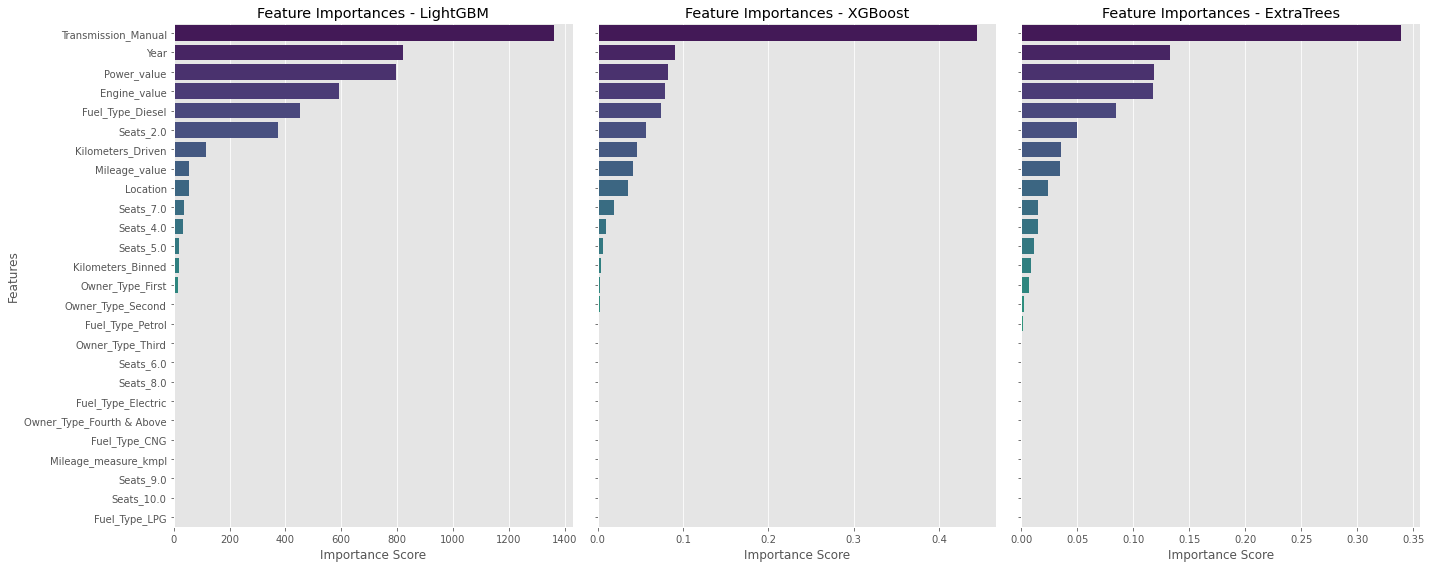

In [88]:
# Feature importance
lgb_best_model = lgb_grid_search.best_estimator_
xgb_best_model = xgb_grid_search.best_estimator_
et_best_model = et_grid_search.best_estimator_

lgb_importance = lgb_best_model.feature_importances_
xgb_importance = xgb_best_model.feature_importances_
et_importance = et_best_model.feature_importances_

# Create DataFrames to hold feature importances for each model
lgb_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_importance
}).sort_values(by='Importance', ascending=False)

xgb_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)

et_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': et_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn on subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# LightGBM plot
sns.barplot(ax=axes[0], x='Importance', y='Feature', data=lgb_feature_importance_df, palette='viridis')
axes[0].set_title('Feature Importances - LightGBM')
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('Features')

# XGBoost plot
sns.barplot(ax=axes[1], x='Importance', y='Feature', data=xgb_feature_importance_df, palette='viridis')
axes[1].set_title('Feature Importances - XGBoost')
axes[1].set_xlabel('Importance Score')
axes[1].set_ylabel('')

# ExtraTrees plot
sns.barplot(ax=axes[2], x='Importance', y='Feature', data=et_feature_importance_df, palette='viridis')
axes[2].set_title('Feature Importances - ExtraTrees')
axes[2].set_xlabel('Importance Score')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

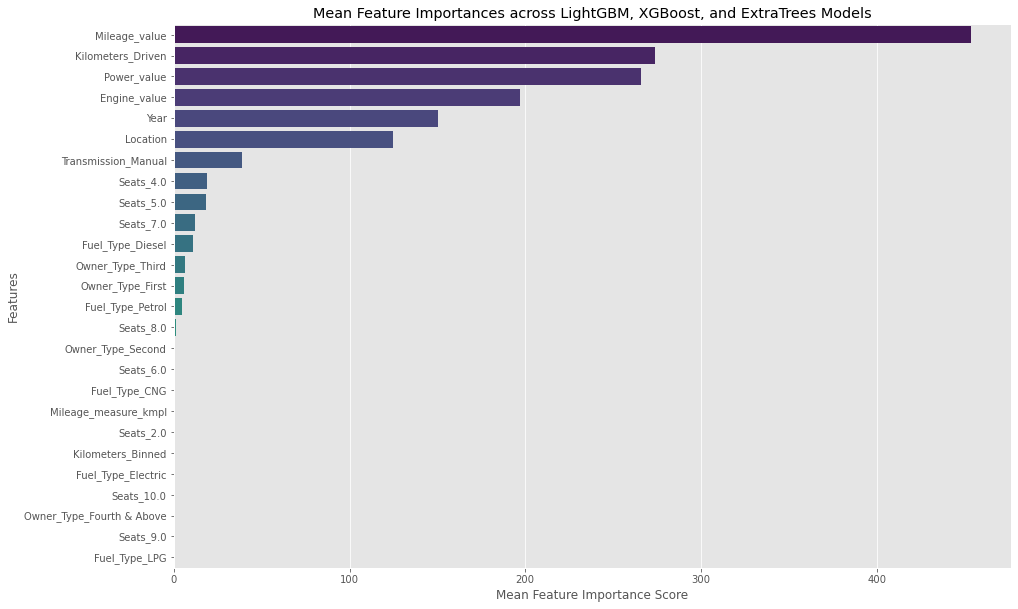

In [89]:
# Calculate mean importance across all models for each feature
mean_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Importance': np.mean([lgb_importance, xgb_importance, et_importance], axis=0)
})

# Sort mean_importance_df by Mean Importance in descending order
mean_importance_df = mean_importance_df.sort_values(by='Mean Importance', ascending=False)

# Plot the mean feature importances using seaborn
plt.figure(figsize=(15, 10))
sns.barplot(x='Mean Importance', y='Feature', data=mean_importance_df, palette='viridis')
plt.xlabel('Mean Feature Importance Score')
plt.ylabel('Features')
plt.title('Mean Feature Importances across LightGBM, XGBoost, and ExtraTrees Models')
plt.show()

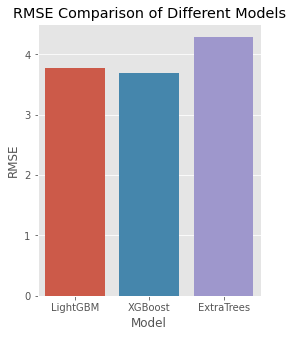

In [90]:
# Visualization of RMSE comparison
results = {
    'Model': ['LightGBM', 'XGBoost', 'ExtraTrees'],
    'RMSE': [np.sqrt(np.abs(lgb_grid_search.best_score_)), np.sqrt(np.abs(xgb_grid_search.best_score_)), np.sqrt(np.abs(et_grid_search.best_score_))]
}

results_df = pd.DataFrame(results)

plt.figure(figsize=(4, 5))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('RMSE Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()